In [53]:
%matplotlib inline

# used throughout
import time
import numpy as np

# data ingress from file
import os
import pickle

# lemmatisation
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

# Graphing step
import matplotlib.pyplot as plt

# Path to arxiv data
filepath = "../Data/arxiv_sorted/"

## Tools

In [149]:
def quarter(created):
    '''
    Takes a string in the format YYYY-MM-DD and returns a year quarter where the quarter is a number from 0 to 3
    
    For instance, >>>quarter(2010-03-11) returns 2010-0
    '''
    return str(created[0:4]) + '-' + str(int(np.floor((int(created[5:7])-1)/3)))


def graph():
    '''
    Standard graph formatting used in the rest of this notebook
    '''
    fig = plt.figure(figsize=(12,6)) 
    ax = fig.subplots(1,1)
    ax.set_xlabel('Publication quarter', fontsize=12)
    ax.set_ylabel('Term popularity (%)', fontsize=12)
    ax.set_xlim([0,40])
    ax.grid()
    plt.xticks(np.arange(0,42,4), ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'])
    return ax
    
def moving_average(data_series, ma_length):
    original_x = np.arange(0,len(data_series))
    new_x = original_x[ma_length-1:]
    y = np.convolve(data_series, np.ones((ma_length,))/ma_length, mode='valid')
    return new_x, y
                    

## Import data

In [55]:
data = {}
for file in os.listdir(filepath):
    data[int(file.split('.')[0])] = pickle.load(open(filepath+file, "rb"))

## Stopwords

We use a fairly comprehensive list of stopwords

In [56]:
with open('../Resources/stopwords.txt', 'r') as f:
    stop = set(f.read().splitlines())
    
for year in range(1950, 2020):
    stop.add(str(year))
    

## Apply a lemmatisation step

Initial experiments seemed to imply that stemming is too harsh a choice here. However, to avoid repeated words popping up, we do apply a lemmatisation step (stripping trailing 's's off words, for example.

In [88]:
t0 = time.time()

# Download the lemmatisesr
wnl = WordNetLemmatizer()


count = CountVectorizer(strip_accents='ascii',  
                        stop_words=stop, 
                        min_df=1)

# Create a tokeniser. This will split text into tokens based on punctuation
tokeniser = count.build_analyzer()
    
lemmatised_data = []
for year in range(2008,2019):
    for doc in data[year]:
        
        # Grab out the text. 
        text = doc['title'] + ' . ' + doc['abstract']
        
        lemmas = []
        for word in tokeniser(text):
            lemmas.append(wnl.lemmatize(word))
        
        lemmatised_data.append({'year_quarter': quarter(doc['created']), 'text': ' '.join(lemmas)})

print(time.time()-t0)

92.28322720527649


### Number of articles that we have kept?

In [89]:
print(len(lemmatised_data))

156174


### What do the articles look like after they have been lemmatised?

In [59]:
print('Before:')
print(data[2008][0]['title'])
print(data[2008][0]['abstract'])
print()
print('After')
print(lemmatised_data[0]['text'])

Before:
is randomness "native" to computer science?
we survey the kolmogorov's approach to the notion of randomness through the kolmogorov complexity theory. the original motivation of kolmogorov was to give up a quantitative definition of information. in this theory, an object is randomness in the sense that it has a large information content. afterwards, we present parts of the work of martin-lof, schnorr, chaitin and levin which supply a mathematical notion of randomness throughout diverse theories from the the 60' up to recently.

After
randomness native computer science survey kolmogorov approach notion randomness kolmogorov complexity theory original motivation kolmogorov quantitative definition theory object randomness sense large content part work martin lof schnorr chaitin levin supply mathematical notion randomness diverse theory 60


## Get the vocabulary of the whole dataset

Before vectorising, we gather together a vocabulary based on the entire dataset

We choose
- ngram range = 1 to 3
- a minimum document frequency of 5 throughout the entire dataset

Questions:
- should we be doing this year to year? does the aggregated minimum document frequncy bias the data towards later years where there were more documents?

Issues:
- The dating information is separated here. This makes the method more prone to errors since it needs to be rematched based on index later

In [60]:
t0 = time.time()

vectorizer = CountVectorizer(strip_accents='ascii', 
                             ngram_range=(1,3), 
                             min_df=5)

vector = vectorizer.fit_transform([d['text'] for d in lemmatised_data])
vocabulary = vectorizer.vocabulary_
print(time.time()-t0)

166.20961928367615


### Number of items in the vocabulary?

In [61]:
len(vocabulary)

539124

## Go year by year and vectorise

In [94]:
# Store the vectors in a list ordered by year
year_quarters = []
vectors = []

t0 = time.time()
for year in range(2008, 2019):
    for quarter in range(4):
        year_quarter = str(year) + '-' + str(quarter)
        
        # Set up a new vectoriser. We can forgo the stopwords step, since they were all elimimated earlier in the process
        vectorizer = CountVectorizer(strip_accents='ascii', 
                                 ngram_range=(1,3), 
                                 vocabulary=vocabulary)     
        
        # Apply the vectoriser to the data for that year
        year_quarter_data = [d['text'] for d in lemmatised_data if d['year_quarter'] == year_quarter]
        if len(year_quarter_data) > 10:
            year_quarters.append(year_quarter)
            
            # vectorise
            vector = vectorizer.fit_transform(year_quarter_data)
            
            # We are only interested in document frequency of words. It does not matter if one
            # word appears multiple times in a document; it should be treated as one occurence
            # Therefore, we threshold the vector so that each cell is 0 (word did not appear)
            # or 1 (word did appear)
            vector[vector>1] = 1
            
            # We save document frequency/number of documents
            # this is an improvement to an erronous earlier version which took term frequency/number of words in all documents
            summed = np.sum(vector, axis=0)/vector.shape[0]
            
            # We save a squeezed np array version of this (original is a Matrix)
            vectors.append(np.squeeze(np.asarray(summed)))
            

# Stack vectors vertically, so that we have the full history of popularity/time for each term
stacked_vectors = np.stack(vectors, axis=1)

print(time.time()-t0)

69.3020691871643


## Detect keywords using MACD

We use a modified version of the Moving-Average-Convergence-Divergence method to detect interesting keywords. Since we are looking at historical rather than current data, we judge that the term is interesting if the difference between the long and short averages is greater than some threshold, normalised by the all-time maximum of the long moving average.

Some parts of this methodology are shaky, particularly the normalisation step. We also threshold out terms that never rise above a given level of popularity.

### Quick example

Pretty graphs of moving averages for a particular word

In [151]:
term = 'big data'
long_ma_length = 20
short_ma_length = 10

# Get the term popularity over time
index = vocabulary['big data']
prevalence = stacked_vectors[index,:]
x = np.arange(0,42)

# Get the moving averages
long_x, long_y = moving_average(prevalence, long_ma_length)
short_x, short_y = moving_average(prevalence, short_ma_length)


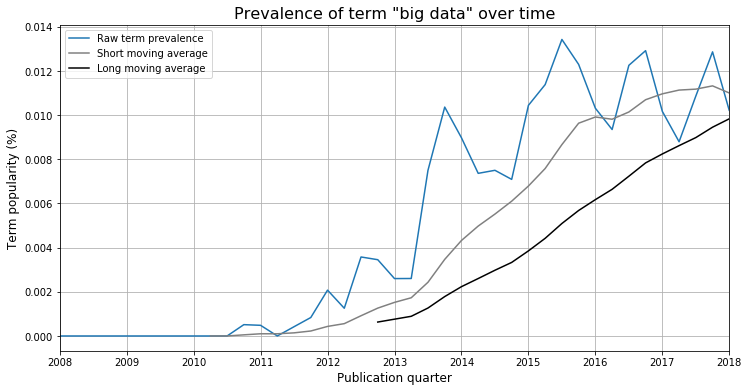

In [156]:
ax = graph()
ax.plot(x, prevalence, label='Raw term prevalence')
ax.plot(short_x, short_y, color='grey', label='Short moving average')
ax.plot(long_x, long_y, color='black', label='Long moving average')
ax.set_title('Prevalence of term "' + term + '" over time', fontsize=16)
ax.legend()

In [78]:
significance_thresholds = []


matrix([[  60, 1107,   40, ...,    6,   26,   11]], dtype=int64)

In [74]:
uni_significance_thresh = 0.0001
bi_significance_thresh = 0.00005
#tri_significance_thresh = 0.000001

ma1 = 21
ma2 = 10

bursts = []
for keyword in vocabulary.keys():
    time_series = vectors_tf[vocabulary[keyword]]

    long_average = np.convolve(time_series, np.ones((ma1,))/ma1, mode='valid')

    #trimmed, to be the same length as the long average
    short_average = np.convolve(time_series, np.ones((ma2,))/ma2, mode='valid')[int(ma1-ma2):]

    # threshold out insignificant words
    if ' ' in keyword:
        if np.max(long_average) < bi_significance_thresh:
            continue
    else:
        if np.max(long_average) < uni_significance_thresh:
            continue
    
    # Calculate the score... oh wait. mmm.... should it be as a proportion
    diff = np.abs(long_average-short_average)
    
    # THIS PART IS CRUCIAL -- the score we use is the max diff/long average at max diff
    score = np.max(diff)/long_average[np.argmax(diff)]
    
    if score > 0.35:
        bursts.append([keyword, score])


23377724

In [ ]:
matrix([[  74, 1370,   53, ...,    8,   32,   23]], dtype=int64)

In [ ]:
vectors = []

abstracts = defaultdict(list)
for year in range(2008,2019):
    for doc in data[str(year)]:
        
   

        quarter = int(np.floor((int(doc['created'][5:7])-1)/3))
        
        abstracts[str(year)+'-'+str(quarter)].append(doc['title'] + ' . ' + doc['abstract'])

In [ ]:
vectors_idf = []
vectors_tf = []

t0 = time.time()
for key in sorted(abstracts.keys()):
    vectorizer_idf = TfidfVectorizer(strip_accents='ascii', 
                             ngram_range=(1,3), 
                             stop_words=stop,
                             vocabulary=vocabulary)
    
    vectorizer_tf = CountVectorizer(strip_accents='ascii', 
                             ngram_range=(1,3), 
                             stop_words=stop,
                             vocabulary=vocabulary)
    
    vector_idf = vectorizer_idf.fit_transform(abstracts[key])
    vector_tf = vectorizer_tf.fit_transform(abstracts[key])
    
    summed_idf = np.sum(vector_idf,axis=0)/np.sum(vector_idf)
    summed_tf = np.sum(vector_tf,axis=0)/np.sum(vector_tf)
    
    vectors_idf.append(np.squeeze(np.asarray(summed_idf)))
    vectors_tf.append(np.squeeze(np.asarray(summed_tf)))

vectors_idf = np.stack(vectors_idf, axis=1)
vectors_tf = np.stack(vectors_tf, axis=1)
print(time.time()-t0)

In [ ]:
# Split the dataset up into year quarters
abstracts = defaultdict(list)
#for year in range(2008,2019):
#    for doc in data[str(year)]:
#        quarter = int(np.floor((int(doc['created'][5:7])-1)/3))
#        
#        abstracts[str(year)+'-'+str(quarter)].append(doc['title'] + ' . ' + doc['abstract'])


for doc in stemmed_data:
    quarter = int(np.floor((int(doc['created'][5:7])-1)/3))
    year = doc['created'][0:4]
    abstracts[str(year)+'-'+str(quarter)].append(doc['text'])